In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import sys
sys.path.append('/Users/vsriniv/Documents/Research/Github/PatchSim')
import patchsim as sim
import matplotlib.ticker as plticker
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Running PatchSim

In [2]:
stages = 3
cp_timings = []
for s in range(stages):
    cfg = sim.read_config('../data/patchsim/manual_cps/cfg_stage{}.txt'.format(s))
    cp_timings.append(int(cfg['Duration']))
    sim.run_disease_simulation(cfg,write_epi=True)

cp_timings = np.cumsum(cp_timings)

out_df = pd.DataFrame()
for s in range(stages):
    temp_df = pd.read_csv('../outputs/sample{}.out'.format(s),delimiter=' ',header=None,index_col=0)       
    if s==0:
        out_df = temp_df.copy(deep=True)
    else:
        temp_df.columns = [x+len(out_df.columns) for x in temp_df.columns]
        out_df = out_df.join(temp_df)


## National ground truth vs simulated cases

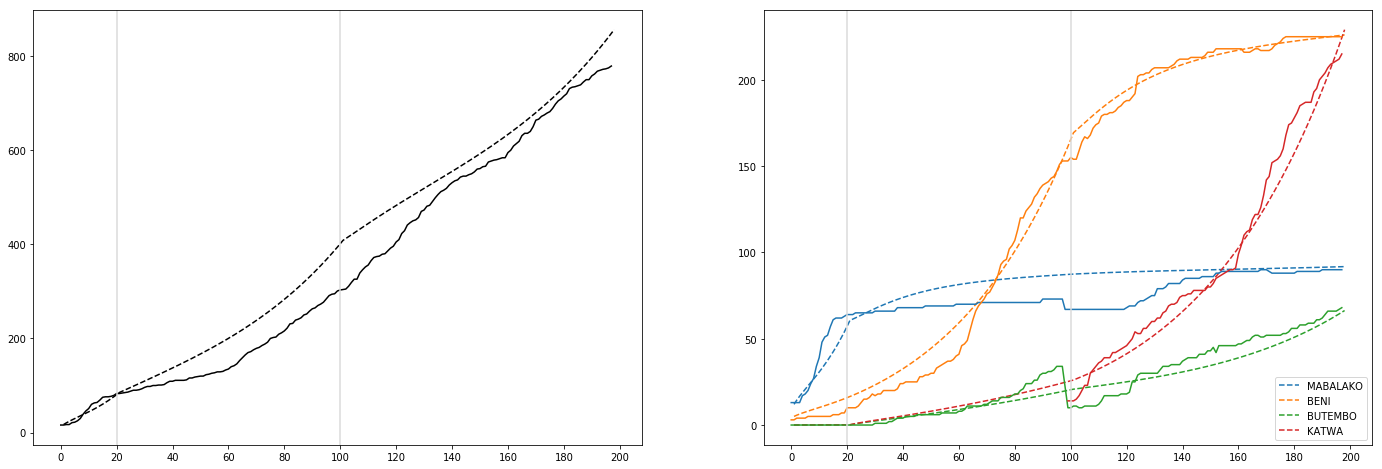

In [3]:
f,axarr = plt.subplots(1,2,figsize=(24,8))

out_df.sum().cumsum().plot(label='Simulated',ax=axarr[0],color='k',style='--')
gt = pd.read_csv('../data/Ebola_Updated_Feb18.csv', delimiter='\t')
gt['Date'] = gt.date.apply(lambda x: datetime.strptime(str(x),'%Y%m%d'))
gt['Ob_Day'] = gt.Date.apply(lambda x : (x - datetime.strptime('20180805','%Y%m%d')).days)
gt = gt[gt.Date>=datetime.strptime('20180805','%Y%m%d')] ## Starting on August 5th, the first non-NaN value

axarr[0].plot(gt[gt.health_zone=='all'].total_c.values,label='Ground Truth',color='k')

key_hzs = ['MABALAKO','BENI','BUTEMBO','KATWA'] 
out_df.loc[key_hzs].T.cumsum().plot(ax=axarr[1], style='--')
axarr[1].legend().set_title('')
axarr[1].set_prop_cycle(None)
for h in key_hzs:
    gt[gt.health_zone==h.capitalize()].reset_index().plot(y='total_c',ax=axarr[1],legend=None)

for t in cp_timings[:-1]:
    axarr[0].axvline(t,color='#dbdbdb')
    axarr[1].axvline(t,color='#dbdbdb')
    
loc = plticker.MultipleLocator(base=20) 
axarr[0].xaxis.set_major_locator(loc)
axarr[1].xaxis.set_major_locator(loc)